# アヤメの分類

グリッドサーチやランダムサーチでももちろん良いのですが，  
実用を考えOptunaでの実装になりました  
また，k分割交差検証によるハイパーパラメータの調整後性能評価をしたコードになっています

## Import & 初期化

In [ ]:
!pip install optuna
## 基本のPythonライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from functools import partial
import seaborn as sns
%matplotlib inline

## Sklearnライブラリ
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import load_iris
from sklearn.svm import SVC

     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 209 kB 48.5 MB/s 
     |████████████████████████████████| 80 kB 8.3 MB/s 
     |████████████████████████████████| 75 kB 3.5 MB/s 
     |████████████████████████████████| 149 kB 64.1 MB/s 
     |████████████████████████████████| 112 kB 62.6 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=edd9760bdf1d0c12eaec53aa1dea83d7fa52e67b09aa7a8885470c5659ac36f5
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
## modelの格納
gmodels = []
hmodels = []
amodels = []

## データセット構築

In [ ]:
## アヤメデータのインスタンス生成
heacet = load_iris()
heacet_data = pd.DataFrame(heacet.data, columns=["sepal_length","sepal_width","petal_length","petal_width"])
heacet_target = pd.DataFrame(heacet.target, columns=["category"])

## objectives

In [ ]:
def objectives(X, y, trial):

  params = {
  'kernel': trial.suggest_categorical('kernel', ['linear','rbf','poly','sigmoid']),
  'gamma': trial.suggest_loguniform('gamma', 1e-5,1),
  'C': trial.suggest_loguniform('C',1e-5,1),
  }

  model = SVC(**params, random_state = 0)

  kf = KFold(n_splits=3, shuffle=True, random_state=0)
  scores = cross_validate(model, X=X, y=y.values.ravel(), scoring='f1_macro', cv = kf)

  return scores['test_score'].mean()

## Optunaの利用

In [ ]:
## Train_test_split
X_train, X_test, y_train, y_test = train_test_split(heacet_data, heacet_target, random_state=0)

## Oputna
obj_gaku = partial(objectives, X_train.loc[:,["sepal_length","sepal_width"]], y_train)
obj_hana = partial(objectives, X_train.loc[:,["petal_length","petal_width"]], y_train)
obj_all = partial(objectives, X_train, y_train)

study_gaku = optuna.create_study(direction="maximize")
study_hana = optuna.create_study(direction="maximize")
study_all_features = optuna.create_study(direction="maximize")

study_gaku.optimize(obj_gaku, n_trials=30)
study_hana.optimize(obj_hana, n_trials=30)
study_all_features.optimize(obj_all, n_trials=30)

## Models
gakuhen_model = SVC(**study_gaku.best_params, random_state=0)
hanabira_model = SVC(**study_hana.best_params, random_state=0)
all_features_model = SVC(**study_all_features.best_params, random_state=0)

## Fit
gakuhen_trained = gakuhen_model.fit(X_train.loc[:,["sepal_length","sepal_width"]], y_train.values.ravel())
hanabira_trained = hanabira_model.fit(X_train.loc[:,["petal_length","petal_width"]], y_train.values.ravel())
all_features_trained = all_features_model.fit(X_train, y_train.values.ravel())

## Predict
gakuhen_predict = gakuhen_trained.predict(X_test.loc[:,["sepal_length","sepal_width"]])
hanabira_predict = hanabira_trained.predict(X_test.loc[:,["petal_length","petal_width"]])
all_features_predict = all_features_trained.predict(X_test)

## Append Models
gmodels.append(gakuhen_trained)
hmodels.append(hanabira_trained)
amodels.append(all_features_trained)

[I 2021-11-24 03:36:45,817] A new study created in memory with name: no-name-6f0bb968-f2c7-4368-a2ee-af7a659377f3
[I 2021-11-24 03:36:45,820] A new study created in memory with name: no-name-86efabd6-4916-42a9-b999-e0a5ce9a96a9
[I 2021-11-24 03:36:45,824] A new study created in memory with name: no-name-704309f6-e137-4569-91eb-08e28f92e80d
[I 2021-11-24 03:36:45,852] Trial 0 finished with value: 0.8098459462348351 and parameters: {'kernel': 'linear', 'gamma': 0.09126117346099316, 'C': 0.2346916356063802}. Best is trial 0 with value: 0.8098459462348351.
[I 2021-11-24 03:36:45,887] Trial 1 finished with value: 0.16153215241361138 and parameters: {'kernel': 'rbf', 'gamma': 0.02173082076349304, 'C': 0.0001260299123405153}. Best is trial 0 with value: 0.8098459462348351.
[I 2021-11-24 03:36:45,915] Trial 2 finished with value: 0.16153215241361138 and parameters: {'kernel': 'rbf', 'gamma': 0.03728218233035708, 'C': 0.0009991268090903437}. Best is trial 0 with value: 0.8098459462348351.
[I 20

## Heatmap

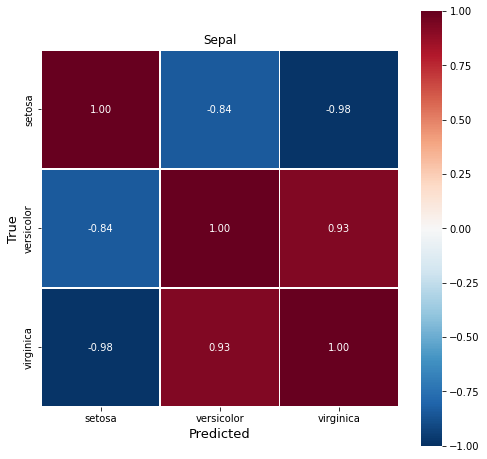

In [ ]:
## がく片
fig, ax = plt.subplots(figsize=(8,8)) 
cm_gaku = confusion_matrix(y_test, gakuhen_predict)
cm_gaku = pd.DataFrame(data=cm_gaku, index=["setosa", "versicolor", "virginica"], 
                           columns=["setosa", "versicolor", "virginica"])
sns.heatmap(cm_gaku.corr(), fmt='.2f', square=True, cbar=True, annot=True, cmap="RdBu_r",vmax=1, vmin=-1,linecolor="white", linewidths=.5)
plt.title('Sepal')
plt.xlabel("Predicted", fontsize=13, rotation=0)
plt.ylabel("True", fontsize=13)
plt.show()

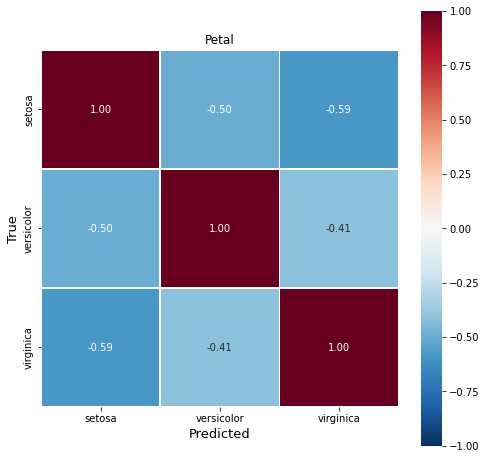

In [ ]:
## 花びら
fig, ax = plt.subplots(figsize=(8,8)) 
cm_hana = confusion_matrix(y_test, hanabira_predict)
cm_hana = pd.DataFrame(data=cm_hana, index=["setosa", "versicolor", "virginica"], 
                           columns=["setosa", "versicolor", "virginica"])
sns.heatmap(cm_hana.corr(), fmt='.2f', square=True, cbar=True, annot=True, cmap="RdBu_r",vmax=1, vmin=-1,linecolor="white", linewidths=.5)
plt.title('Petal')
plt.xlabel("Predicted", fontsize=13, rotation=0)
plt.ylabel("True", fontsize=13)
plt.show()

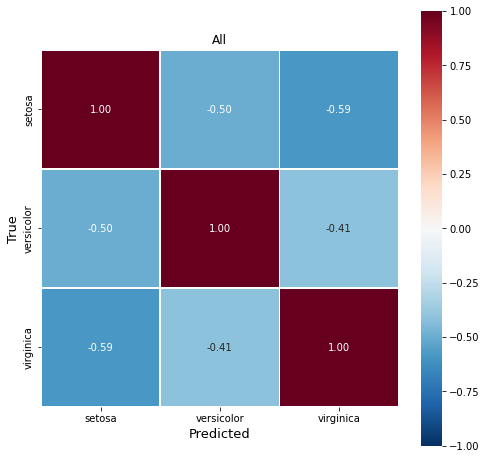

In [ ]:
## 全て
fig, ax = plt.subplots(figsize=(8,8)) 
cm_all = confusion_matrix(y_test, all_features_predict)
cm_all = pd.DataFrame(data=cm_all, index=["setosa", "versicolor", "virginica"], 
                           columns=["setosa", "versicolor", "virginica"])
sns.heatmap(cm_all.corr(), fmt='.2f', square=True, cbar=True, annot=True, cmap="RdBu_r",vmax=1, vmin=-1,linecolor="white", linewidths=.5)
plt.title('All')
plt.xlabel("Predicted", fontsize=13, rotation=0)
plt.ylabel("True", fontsize=13)
plt.show()

## 性能評価

In [ ]:
## Accuracy
print('Accuracy:')
print(f'Gakuhen: {accuracy_score(y_test, gakuhen_predict)}')
print(f'Hanabira: {accuracy_score(y_test, hanabira_predict)}')
print(f'All_features: {accuracy_score(y_test, all_features_predict)}')
print()
## Classification report
print('Classification report:')
print(f'Gakuhen: {classification_report(y_test, gakuhen_predict)}')
print(f'Hanabira: {classification_report(y_test, hanabira_predict)}')
print(f'All_features: {classification_report(y_test, all_features_predict)}')

Accuracy:
Gakuhen: 0.7368421052631579
Hanabira: 0.9736842105263158
All_features: 0.9736842105263158

Classification report:
Gakuhen:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.69      0.69      0.69        16
           2       0.44      0.44      0.44         9

    accuracy                           0.74        38
   macro avg       0.71      0.71      0.71        38
weighted avg       0.74      0.74      0.74        38

Hanabira:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.94      0.97        16
           2       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38

All_features:               precision    recall  f1-score   support

           0       1.00   